# Install Libraries

In [ ]:
!pip install pytube ultralytics filterpy

# Import Dependencies

In [2]:
from pytube import YouTube
import os
import cv2
from filterpy.kalman import KalmanFilter
from google.colab import drive
from google.colab import files
from google.colab import userdata
# google patch for cv2.imshow
from google.colab.patches import cv2_imshow
import numpy as np
from ultralytics import YOLO

# Download Videos

Convenience function which uses the PyTube API to download the YouTube videos specified in the assignment and store them in my Google Drive

In [3]:
def download_videos(video_id_list, output_path="."):
    """
    Download videos from YouTube based on a list of video IDs using PyTube API

    Paarameters:
        video_id_list (list): A list of YouTube video IDs to download.
        output_path (str, optional): The directory where the downloaded videos will be saved. Defaults to ./videos
    """
    for video_id in video_id_list:
      try:
        yt = YouTube(f"https://www.youtube.com/watch?v={video_id}")
        video = yt.streams.filter(file_extension='mp4', resolution='360p').first()
        video.download(output_path)
        print(f"Video downloaded successfully: {yt.title}")
      except Exception as e:
        print(f"Error downloading video: {e}")

In [4]:
# Video IDs specified in assignment
video_id_list = ["WeF4wpw7w9k", "2NFwY15tRtA", "5dRramZVu2Q"]

# Get current directory, define subdirectory for videos, and define full output path
current_directory = os.getcwd()
videos_directory = "videos"
output_path = os.path.join(current_directory, videos_directory)

# Join the current directory with the videos directory and download videos
download_videos(video_id_list, output_path)

# save all mp4 paths to video_paths list
video_paths = []
for root, dirs, files in os.walk(output_path):
  for file in files:
    full_path = os.path.join(root, file)
    video_paths.append(full_path)

# keep in sorted order for consistent IDs in PG instance
video_paths.sort()

for video_path in video_paths:
  print(video_path)

Video downloaded successfully: Cyclist and vehicle Tracking - 1
Video downloaded successfully: Cyclist and vehicle tracking - 2
Video downloaded successfully: Drone Tracking Video
/content/videos/Cyclist and vehicle Tracking - 1.mp4
/content/videos/Cyclist and vehicle tracking - 2.mp4
/content/videos/Drone Tracking Video.mp4


## Task 3: Kalman Filter (50 points)

Use the  [filterpy](https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html) library to implement Kalman filters that will track the cyclist and the vehicle (if present) in the video. You will need to use the detections from the previous task to initialize and run the Kalman filter.

You need to deliver a video that contains the trajectory of the objects as a line that connects the pixels that the tracker indicated. You can use the `ffmpeg` command line tool and OpenCV to superpose the bounding box of the drone on the video as well as plot its trajectory.

Suggest methods that you can use to address  false positives and how the tracker can help you in this regard.

You will need to have one Kalman filter to track each of the required and present objects (cyclist and vehicle).

# Convenience Functions

In [69]:
def euclidean_distance(array_1, arr_2):
    """
    Compute the Euclidean distance between two 2D arrays.

    Parameters:
      array_1 (numpy.ndarray): First 2D array shape (2,).
      arr_2 (numpy.ndarray): Second 2D array, will also work with shape (2, 1).

    Returns:
      float: Euclidean distance between the two arrays.
    """
    if(arr_2.shape == (2,1)): # Hacky shape check/fix
      array_2 = np.zeros(2)
      array_2[0] = arr_2[0,0]
      array_2[1] = arr_2[1,0]
    else:
      array_2 = arr_2

    # Compute the squared differences between corresponding elements
    squared_diff = (array_1 - array_2) ** 2

    # Sum the squared differences along the last axis (assuming arrays are 2D)
    squared_diff_sum = np.sum(squared_diff, axis=-1)

    # Take the square root to get the Euclidean distance
    distance = np.sqrt(squared_diff_sum)

    return distance

def find_nearest_neighbor(results, class_id, prev_pred):
  """
  Find the nearest neighbor object centroid among detected objects.

  Parameters:
    results (Results): Results object from Ultralytics Yolo V8 detection results.
    class_id (int): The class ID of the object to be detected (car or biker in this context).
    prev_pred (numpy.ndarray): Previous prediction of car centroid.

  Returns:
    numpy.ndarray: The nearest neighbor object centroid if an object of the specified class_id is found, otherwise the previous prediction.
  """
  tracked_object_centroids = []
  ret_z = []
  for result in results:
    boxes = result.boxes
    for box in boxes:
      # check if detected object is a class_id object, if it is, add to list of tracked object centroids
      if int(box.cls.item()) == class_id:
        x, y, w, h = box.xywh[0].tolist()
        cur_z = np.array([x + w/2, y + h/2])
        if len(cur_z) > 1:
          tracked_object_centroids.append(cur_z)

  # find NN object, then set ret_z
  min_dist = float('inf')
  for centroid in tracked_object_centroids:
    dist_from_pred = euclidean_distance(centroid, prev_pred)
    if dist_from_pred < min_dist:
      min_dist = dist_from_pred
      ret_z = centroid

  return ret_z if len(ret_z) > 1 else prev_pred # return prev_pred if no objects from specified class are detected

def find_nearest_object_centroid(results, prev_pred, object_id):
  """
  Find the nearest centroid of a specific object among the detected objects.

  Parameters:
    results (Results): Results object from Ultralytics Yolo V8 detection results.
    prev_pred (numpy.ndarray): Previous predicted centroid of the object.
    object_id (int): The ID of the object to track.

  Returns:
    numpy.ndarray: The centroid of the nearest detected object if found, otherwise the previous prediction.
  """
  z = []
  if(len(prev_pred) < 1 and len(results) < 1):  # Do nothing until first object is detected
    return []
  elif len(prev_pred) < 1:  # First detected results
    for result in results:
      boxes = result.boxes
      for box in boxes:
        # Check if detected object is a car object (class 1), if it is, add centroid. naive, but works because other objects leave z = []
        if int(box.cls.item()) == object_id:
          x, y, w, h = box.xywh[0].tolist()
          z = np.array([x + w/2, y + h/2])
      return z
  elif(len(results) < 1):
    # display new predicted position based on old predicted position
    return prev_pred
  else:
    # update KF with position of NN and set prev_pred
    return find_nearest_neighbor(results, object_id, prev_pred)

In [75]:
def initialize_kalman_filter(x0, y0):
    """
    Initialize a Kalman Filter for tracking a 2D object.

    Parameters:
      x0 (float): Initial x-coordinate of the object.
      y0 (float): Initial y-coordinate of the object.

    Returns:
      KalmanFilter: Initialized Kalman Filter object.

    This function initializes a Kalman Filter for tracking a 2D object with specified initial
    coordinates (x0, y0). It sets up the Kalman Filter with the necessary parameters including
    initial state, covariance matrix, state transition matrix, process noise covariance, measurement
    function, and measurement noise covariance. The function returns the initialized Kalman Filter
    object ready for use in tracking applications.
    """
    x_v0 = 0             # initial x velociy
    y_v0 = 0             # initial y velocity
    x0_std = 300         # x standard deviation
    y0_std = 300         # y standard deviation
    x_v0_std = 10        # x velocity standard deviation
    y_v0_std = 10        # y velocity standard deviation
    dt = 1               # delta t
    acc_std = 5          # accelaration standard deviation

    kf = KalmanFilter(4, 2)  # 2-D filter
    kf.x = np.array([[x0], [y0], [x_v0], [y_v0]], np.float32)

    # Covariance Matrix P
    kf.P = np.array([[x0_std**2, 0, 0, 0],
                    [0, y0_std**2, 0, 0],
                    [0, 0, x_v0_std**2, 0],
                    [0, 0, 0, y_v0_std**2]], np.float32)

    # State Transition Matrix (F)
    kf.F = np.array([[1, 0, dt, 0],
                    [0, 1, 0, dt],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]],
                    np.float32)

    # Initial Process Noise Covariance (Q)
    kf.Q = np.matrix([[(dt**4)/4, 0, (dt**3)/2, 0],
                        [0, (dt**4)/4, 0, (dt**3)/2],
                        [(dt**3)/2, 0, dt**2, 0],
                        [0, (dt**3)/2, 0, dt**2]]) * acc_std **2

    # Measurement function (H)
    kf.H = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0]],
                    np.float32)

    # Measurement Noise Covariance (R)
    kf.R = np.array([[1, 0],
                    [0, 1]],
                    np.float32)

    return kf

# First Video Results

See the full video [here](https://drive.google.com/file/d/14W7ChiQRnKRP8J7tEGpJmXRKQ01ql0zB/view?usp=sharing). A sample of frames also displayed below, but video more indicative of performance. I found taking every 10 sample frames helped mitigate the noise from drone movements and led to better KF performance


0: 352x640 1 0 - Person, 25.7ms
Speed: 1.2ms preprocess, 25.7ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 0 - Person, 24.9ms
Speed: 1.6ms preprocess, 24.9ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 24.9ms
Speed: 1.0ms preprocess, 24.9ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 0 - Person, 21.8ms
Speed: 1.3ms preprocess, 21.8ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 17.3ms
Speed: 1.9ms preprocess, 17.3ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 18.5ms
Speed: 1.0ms preprocess, 18.5ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 17.0ms
Speed: 1.1ms preprocess, 17.0ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 17.0ms
Speed: 1.2ms preprocess, 17.0ms inference, 2.8ms postp

<ipython-input-79-24a90a96a036>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_pred, y_pred = map(int, cur_pred) # predicted position


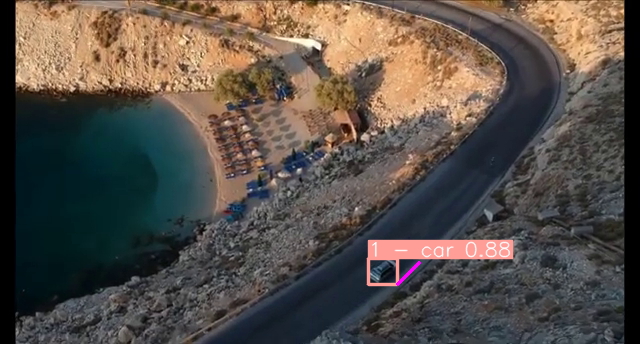


0: 352x640 1 1 - car, 19.2ms
Speed: 1.2ms preprocess, 19.2ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 17.0ms
Speed: 1.1ms preprocess, 17.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 17.0ms
Speed: 1.1ms preprocess, 17.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 17.0ms
Speed: 1.1ms preprocess, 17.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 17.0ms
Speed: 1.2ms preprocess, 17.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 17.0ms
Speed: 1.1ms preprocess, 17.0ms inference, 1.6ms postprocess per image at shape (

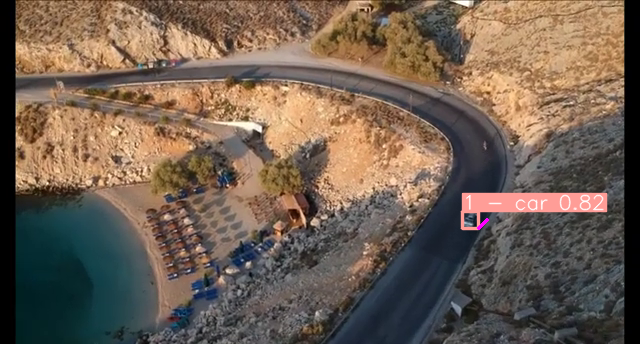


0: 352x640 1 1 - car, 17.3ms
Speed: 4.0ms preprocess, 17.3ms inference, 2.3ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 18.0ms
Speed: 1.3ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 17.0ms
Speed: 1.3ms preprocess, 17.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 17.0ms
Speed: 3.0ms preprocess, 17.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 0 - Person, 1 1 - car, 22.4ms
Speed: 5.8ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 17.4ms
Speed: 12.4ms preprocess, 17.4ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 27.5ms
Speed: 5.8ms preprocess, 27.5ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 37.1ms
Speed: 1.1ms preprocess, 37.1ms inference, 1.7ms postprocess per i

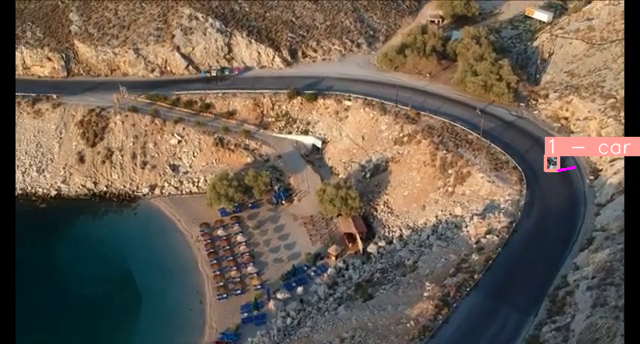


0: 352x640 1 1 - car, 24.5ms
Speed: 1.3ms preprocess, 24.5ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 25.2ms
Speed: 1.1ms preprocess, 25.2ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 24.7ms
Speed: 3.2ms preprocess, 24.7ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 24.5ms
Speed: 1.6ms preprocess, 24.5ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 24.4ms
Speed: 1.2ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 28.2ms
Speed: 1.3ms preprocess, 28.2ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 25.2ms
Speed: 1.4ms preprocess, 25.2ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 27.2ms
Speed: 1.2ms preprocess, 27.2ms inference, 0.9ms postprocess per imag

<ipython-input-79-24a90a96a036>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_cur, y_cur = map(int, z)        # z coordinates


0: 352x640 (no detections), 25.0ms
Speed: 1.8ms preprocess, 25.0ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


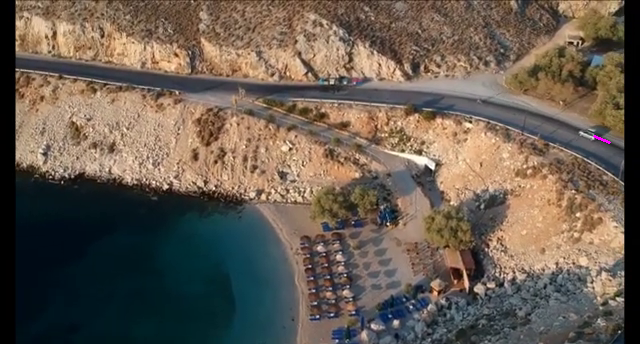


0: 352x640 (no detections), 25.1ms
Speed: 1.4ms preprocess, 25.1ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 35.3ms
Speed: 1.2ms preprocess, 35.3ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 36.3ms
Speed: 4.0ms preprocess, 36.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 30.4ms
Speed: 2.4ms preprocess, 30.4ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 33.5ms
Speed: 1.3ms preprocess, 33.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 33.6ms
Speed: 2.5ms preprocess, 33.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 26.6ms
Speed: 1.1ms preprocess, 26.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 28.7ms
Speed: 1.0ms preprocess, 28.7ms inference, 1.6ms postprocess per image at s

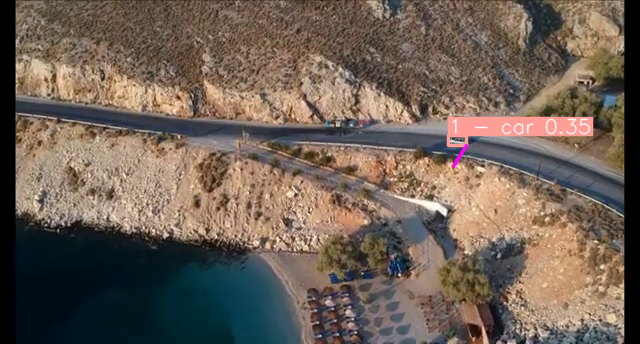


0: 352x640 1 1 - car, 28.1ms
Speed: 1.4ms preprocess, 28.1ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 28.5ms
Speed: 1.2ms preprocess, 28.5ms inference, 5.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 27.5ms
Speed: 4.4ms preprocess, 27.5ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 28.6ms
Speed: 1.1ms preprocess, 28.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 25.0ms
Speed: 1.0ms preprocess, 25.0ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 33.6ms
Speed: 1.2ms preprocess, 33.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 26.0ms
Speed: 1.2ms preprocess, 26.0ms inference, 2.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 1 - cars, 25.0ms
Speed: 1.0ms preprocess, 25.0ms inference, 1.7ms postprocess per image at shape 

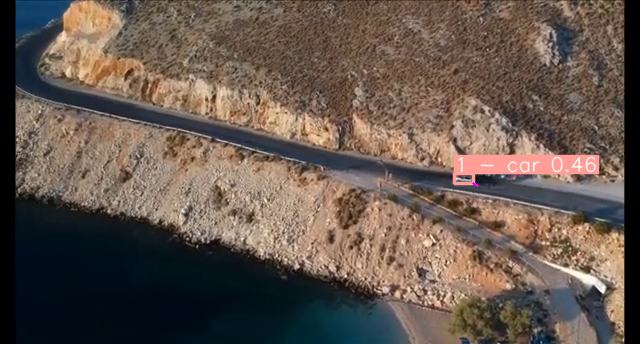


0: 352x640 1 1 - car, 25.1ms
Speed: 1.4ms preprocess, 25.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 26.0ms
Speed: 1.1ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 25.6ms
Speed: 1.2ms preprocess, 25.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 35.2ms
Speed: 1.3ms preprocess, 35.2ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 36.6ms
Speed: 1.1ms preprocess, 36.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 38.3ms
Speed: 1.1ms preprocess, 38.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 29.7ms
Speed: 1.3ms preprocess, 29.7ms inference, 6.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 25.0ms
Speed: 1.4ms preprocess, 25.0ms inference, 1.6ms postprocess per image at shape (

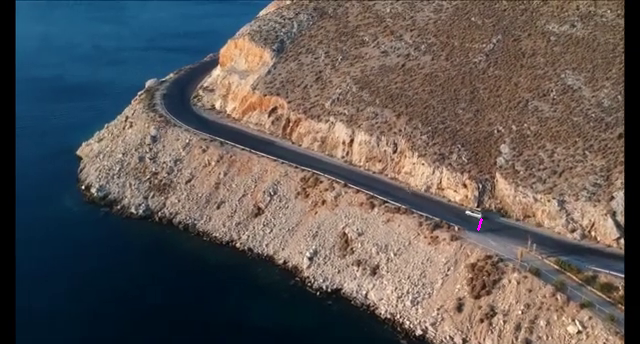


0: 352x640 (no detections), 26.9ms
Speed: 1.4ms preprocess, 26.9ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 27.7ms
Speed: 1.1ms preprocess, 27.7ms inference, 6.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 25.0ms
Speed: 1.2ms preprocess, 25.0ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 36.5ms
Speed: 1.1ms preprocess, 36.5ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 40.6ms
Speed: 1.1ms preprocess, 40.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 33.5ms
Speed: 1.0ms preprocess, 33.5ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 27.6ms
Speed: 1.1ms preprocess, 27.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 25.0ms
Speed: 1.1ms preprocess, 25.0ms i

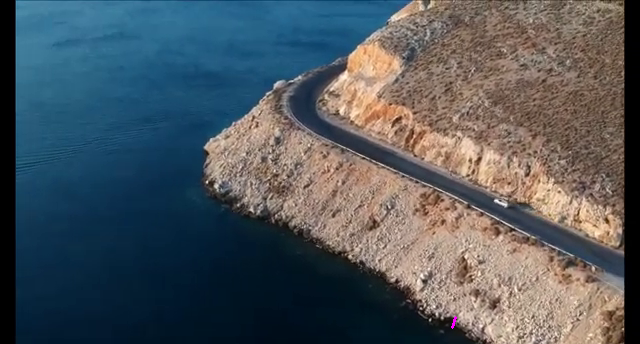


0: 352x640 (no detections), 26.3ms
Speed: 1.3ms preprocess, 26.3ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 27.6ms
Speed: 1.4ms preprocess, 27.6ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 26.9ms
Speed: 1.2ms preprocess, 26.9ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 26.2ms
Speed: 1.5ms preprocess, 26.2ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 32.5ms
Speed: 1.1ms preprocess, 32.5ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 29.6ms
Speed: 1.1ms preprocess, 29.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 25.9ms
Speed: 1.0ms preprocess, 25.9ms inference, 7.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 25.0ms
Speed: 1.0ms preprocess, 25.0ms inference, 6.3ms postproc

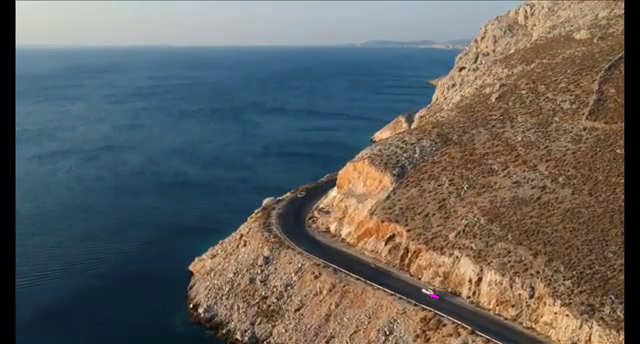


0: 352x640 1 1 - car, 30.2ms
Speed: 1.3ms preprocess, 30.2ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 25.0ms
Speed: 5.9ms preprocess, 25.0ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 30.5ms
Speed: 1.1ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 25.0ms
Speed: 4.0ms preprocess, 25.0ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 24.9ms
Speed: 4.1ms preprocess, 24.9ms inference, 6.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 24.9ms
Speed: 1.0ms preprocess, 24.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 23.9ms
Speed: 1.1ms preprocess, 23.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 28.6ms
Speed: 1.1ms preprocess, 28.6ms inference, 1.8ms postprocess pe

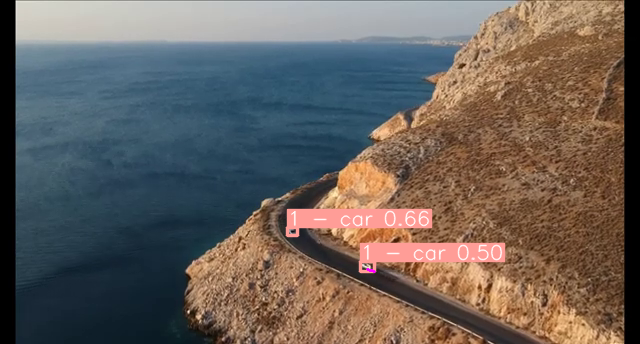


0: 352x640 2 1 - cars, 25.6ms
Speed: 1.3ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 1 - cars, 41.6ms
Speed: 1.2ms preprocess, 41.6ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 1 - cars, 44.9ms
Speed: 1.1ms preprocess, 44.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 1 - cars, 23.9ms
Speed: 1.1ms preprocess, 23.9ms inference, 6.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 1 - cars, 28.1ms
Speed: 1.0ms preprocess, 28.1ms inference, 2.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 1 - cars, 23.9ms
Speed: 1.1ms preprocess, 23.9ms inference, 8.5ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 29.2ms
Speed: 2.3ms preprocess, 29.2ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 1 - cars, 26.1ms
Speed: 1.1ms preprocess, 26.1ms inference, 1.9ms postprocess per image at 

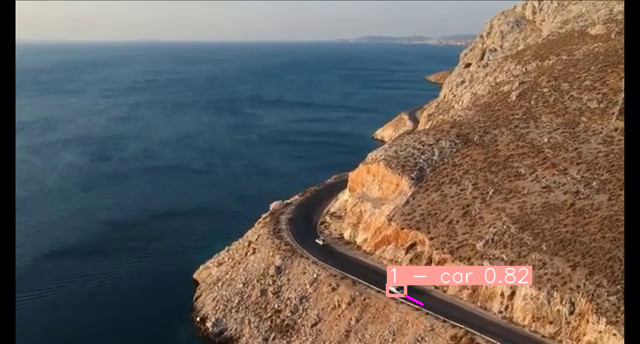


0: 352x640 1 1 - car, 24.0ms
Speed: 1.3ms preprocess, 24.0ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 36.2ms
Speed: 1.1ms preprocess, 36.2ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 29.7ms
Speed: 1.7ms preprocess, 29.7ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 1 - car, 29.5ms
Speed: 1.2ms preprocess, 29.5ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 0 - Person, 1 1 - car, 26.3ms
Speed: 1.2ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 0 - Person, 27.7ms
Speed: 1.4ms preprocess, 27.7ms inference, 5.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 0 - Person, 27.9ms
Speed: 1.1ms preprocess, 27.9ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 28.8ms
Speed: 1.4ms preprocess, 28.8ms inference, 0.9ms postpr

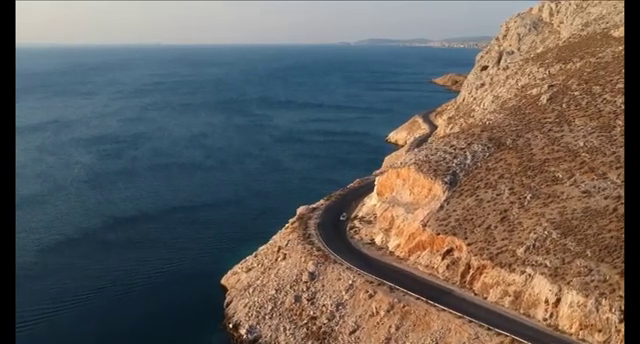


0: 352x640 (no detections), 25.1ms
Speed: 1.8ms preprocess, 25.1ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 25.0ms
Speed: 1.7ms preprocess, 25.0ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 25.0ms
Speed: 1.2ms preprocess, 25.0ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 27.6ms
Speed: 1.1ms preprocess, 27.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 27.5ms
Speed: 1.1ms preprocess, 27.5ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 25.9ms
Speed: 2.0ms preprocess, 25.9ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 29.7ms
Speed: 1.9ms preprocess, 29.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 25.9ms
Speed: 1.2ms preprocess, 25.9ms i

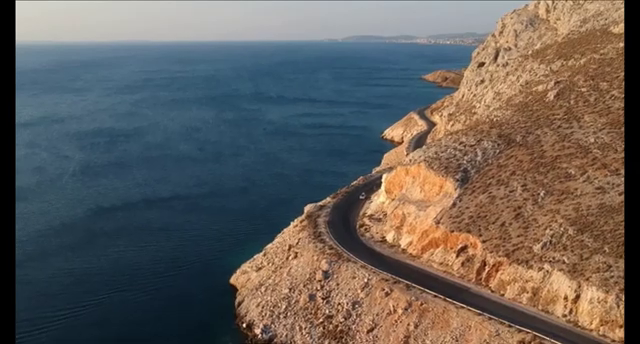


0: 352x640 (no detections), 25.5ms
Speed: 1.4ms preprocess, 25.5ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 26.0ms
Speed: 1.1ms preprocess, 26.0ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 26.7ms
Speed: 1.0ms preprocess, 26.7ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 30.6ms
Speed: 1.0ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


In [79]:
# Load the YOLOv8 model
model_path = "/content/drive/MyDrive/Colab Notebooks/yolov8m_150_epochs_best.pt"
output_video_path = "/content/drive/MyDrive/Colab Notebooks/cyclist_and_vehicle1_kalman_results.mp4"
detection_model = YOLO(model_path)
prev_pred = []
kf_initialized = False
kf = None
car_id = 1

video_path = video_paths[0]
sample_rate = 10
display_rate = 100

cap = cv2.VideoCapture(video_path)
# Get video frame dimensions
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 5, (frame_width, frame_height))

# Variable to count frames
frame_count = 0
prev_pred = []

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()
    cur_pred = []
    z =[]

    if success:
      # Increment the frame count
      frame_count += 1

      # Write every sample_rate'th frame
      if frame_count % sample_rate == 0:
        # Run YOLOv8 inference on the frame
        results = detection_model(frame)
        z = find_nearest_object_centroid(results, prev_pred, car_id)
        if not kf_initialized and len(z) > 0:
          kf = initialize_kalman_filter(z[0], z[1])
          kf_initialized = True

        # Visualize the detection results on the frame
        annotated_frame = results[0].plot()

        if len(z) > 0:
          # Update Kalman Filter and generate prediction
          kf.update(z)
          kf.predict()
          cur_pred = kf.x[:2]

          # Extract coordinates from z and cur_pred
          x_cur, y_cur = map(int, z)        # z coordinates
          x_pred, y_pred = map(int, cur_pred) # predicted position


          # Draw purple line from z to cur_pred
          annotated_frame = cv2.line(annotated_frame, (x_cur, y_cur), (x_pred, y_pred), (255, 0, 255), 2)

          # Display sample of annotated frames
          if frame_count % display_rate == 0:
            cv2_imshow(annotated_frame)

        # Write the annotated frame to the output video
        out.write(annotated_frame)

        prev_pred = cur_pred
    else:
      # Release the video capture object and VideoWriter object
      cap.release()
      out.release()
      break

# Third Video Results

In [ ]:
def initialize_kalman_filter_vid3():
    """
    Initialize Kalman Filter for an object consistently moving from bottom-right to top-left.

    Returns:
    KalmanFilter: Initialized Kalman Filter object.
    """
    # Initialize Kalman Filter
    kf = KalmanFilter(dim_x=6, dim_z=2)
    kf.F = np.array([[1, 0, -1, 0, 0.5, 0],
                     [0, 1, 0, -1, 0, 0.5],
                     [0, 0, 1, 0, 1, 0],
                     [0, 0, 0, 1, 0, 1],
                     [0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 1]])
    kf.H = np.array([[1, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0]])
    kf.R = np.eye(2) * 0.01  # Measurement uncertainty

    # Initial state vector [x, y, vx, vy, ax, ay]
    # Assuming the object starts at the bottom-right corner and moves towards the top-left
    kf.x = np.array([640, 320, -10, -10, 0, 0])

    # Process uncertainty covariance matrix
    kf.Q = np.array([[0.25, 0.5, 0, 0, 0, 0],
                     [0.5, 1, 0, 0, 0, 0],
                     [0, 0, 0.1, 0.2, 0, 0],
                     [0, 0, 0.2, 0.4, 0, 0],
                     [0, 0, 0, 0, 0.1, 0.2],
                     [0, 0, 0, 0, 0.2, 0.4]])

    return kf

In [ ]:
# Load the YOLOv8 model
model_path = "/content/drive/MyDrive/Colab Notebooks/yolov8m_150_epochs_best.pt"
detection_model = YOLO(model_path)
prev_pred = []
kf = initialize_kalman_filter_vid3()
biker_id = 0

video_path = video_paths[2]
sample_rate = 10

cap = cv2.VideoCapture(video_path)
# Variable to count frames
frame_count = 0
prev_pred = []
# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()
    cur_pred = []
    z = []

    if success:
      # Increment the frame count
      frame_count += 1

      # Display every sample_rate'th frame
      if frame_count % sample_rate == 0:
        # Run YOLOv8 inference on the frame
        results = detection_model(frame)

        if(len(prev_pred) < 1 and len(results) < 1):  # Do nothing until first object is detected
          continue
        elif len(prev_pred) < 1:  # First detected results
          for result in results:
            boxes = result.boxes
            for box in boxes:
              # Check if detected object is a car object (class 1), if it is, add centroid. naive, but works because other objects leave z = []
              if int(box.cls.item()) == biker_id:
                x, y, w, h = box.xywh[0].tolist()
                z = np.array([x + w/2, y + h/2])
        elif(len(results) < 1):
          # display new predicted position based on old predicted position
          z = prev_pred
        else:
          # update KF with position of NN and set prev_pred
          z = find_nearest_neighbor(results, biker_id, prev_pred)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        if len(z) > 0:
          # Update Kalman Filter and generate prediction
          kf.update(z)
          kf.predict()
          cur_pred = kf.x[:2]

          # Extract coordinates from z and cur_pred
          x_cur, y_cur = map(int, z)        # z coordinates
          x_pred, y_pred = map(int, cur_pred) # predicted position

          # reinitialize filter if predicted path goes off frame
          if(x_pred > 352 or y_pred > 640 or x_pred < 0 or y_pred < 0):
            kf = initialize_kalman_filter_vid1()

          # Draw purple line from z to cur_pred
          annotated_frame = cv2.line(annotated_frame, (x_cur, y_cur), (x_pred, y_pred), (0, 255, 0), 2)

        # Display the annotated frame
        cv2_imshow(annotated_frame)
        prev_pred = cur_pred
    else:
      # Release the video capture object
      cap.release()
      # Break the loop if the end of the video is reached
      break


In [ ]:
# Load the YOLOv8 model
model_path = "/content/drive/MyDrive/Colab Notebooks/yolov8m_150_epochs_best.pt"
detection_model = YOLO(model_path)
prev_pred = []
kf = initialize_kalman_filter_vid3()
biker_id = 0

video_path = video_paths[2]
output_video_path = "/content/drive/MyDrive/Colab Notebooks/test2_kf_results.mp4"
sample_rate = 1

cap = cv2.VideoCapture(video_path)
# Get video frame dimensions
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 30, (frame_width, frame_height))

# Variable to count frames
frame_count = 0
prev_pred = []

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()
    cur_pred = []
    z =[]

    if success:
      # Increment the frame count
      frame_count += 1

      # Write every sample_rate'th frame
      if frame_count % sample_rate == 0:
        # Run YOLOv8 inference on the frame
        results = detection_model(frame)

        if(len(prev_pred) < 1 and len(results) < 1):  # Do nothing until first car object is detected
          continue
        elif len(prev_pred) < 1:  # First detected results
          for result in results:
            boxes = result.boxes
            for box in boxes:
              # Check if detected object is a car object (class 1), if it is, add centroid. naive, but works because only one car is initially detected in this video
              if int(box.cls.item()) == biker_id:
                x, y, w, h = box.xywh[0].tolist()
                z = np.array([x + w/2, y + h/2])
        elif(len(results) < 1):
          # display new predicted position based on old predicted position
          z = prev_pred
        else:
          # set z to position of NN
          z = find_nearest_neighbor(results, biker_id, prev_pred)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        if len(z) > 0:
          # Update Kalman Filter and generate prediction
          kf.update(z)
          kf.predict()
          cur_pred = kf.x[:2]

          # Extract coordinates from z and cur_pred
          x_cur, y_cur = map(int, z)        # z coordinates
          x_pred, y_pred = map(int, cur_pred) # predicted position

          # reinitialize filter if predicted path goes off frame
          #if(x_pred > 352 or y_pred > 640 or x_pred < 0 or y_pred < 0):
           # kf = initialize_kalman_filter_vid1()
          if(x_pred > 35200 or y_pred > 64000 or x_pred < 0 or y_pred < 0):
            kf = initialize_kalman_filter_vid1()

          # Draw purple line from z to cur_pred
          annotated_frame = cv2.line(annotated_frame, (x_cur, y_cur), (x_pred, y_pred), (0, 255, 0), 2)

        # Write the annotated frame to the output video
        out.write(annotated_frame)

        prev_pred = cur_pred
    else:
      # Release the video capture object and VideoWriter object
      cap.release()
      out.release()
      break

## Extra Bonus (20 points)

```{eval-rst}
.. youtube:: 2hQx48U1L-Y
```

The cyclist in the video goes in and out of occlusions. In addition the object is small making detections fairly problematic without finetuning and other optimizations.  Fintetuning involves using the pretrained model and training it further using images of cyclists from a training dataset such as [VisDrone](https://github.com/VisDrone/VisDrone-Dataset). At the same time,  reducing the number of classes to a much smaller number such as person & bicycle may help.  Also some 2 stage detectors may need to be further optimized in terms of parameters for small objects. See [this paper](https://www.mdpi.com/1424-8220/23/15/6887) for ideas around small object tracking.


```{note}
The extra points can only be awarded in the category of `assignments` and cannot be used to compensate for any other category such as `exams`.
```

In [ ]:
# Download the extra credit video using given video id
ec_video_id = ["2hQx48U1L-Y"]
download_videos(ec_video_id, output_path)
# Save full video path
ec_video_path = "/content/videos/Dji Mavic air 2 drone using litchi app with follow me mode on a bike occluded by trees.mp4"

# Load the YOLOv8 model
model_path = "/content/drive/MyDrive/Colab Notebooks/yolov8m_150_epochs_best.pt"
detection_model = YOLO(model_path)
prev_pred = []
kf = initialize_kalman_filter_vid3()
biker_id = 0

video_path = ec_video_path
output_video_path = "/content/drive/MyDrive/Colab Notebooks/test3_kf_results.mp4"
sample_rate = 1

cap = cv2.VideoCapture(video_path)
# Get video frame dimensions
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 30, (frame_width, frame_height))

# Variable to count frames
frame_count = 0
prev_pred = []

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()
    cur_pred = []
    z =[]

    if success:
      # Increment the frame count
      frame_count += 1

      # Write every sample_rate'th frame
      if frame_count % sample_rate == 0:
        # Run YOLOv8 inference on the frame
        results = detection_model(frame)

        if(len(prev_pred) < 1 and len(results) < 1):  # Do nothing until first car object is detected
          continue
        elif len(prev_pred) < 1:  # First detected results
          for result in results:
            boxes = result.boxes
            for box in boxes:
              # Check if detected object is a car object (class 1), if it is, add centroid. naive, but works because only one car is initially detected in this video
              if int(box.cls.item()) == biker_id:
                x, y, w, h = box.xywh[0].tolist()
                z = np.array([x + w/2, y + h/2])
        elif(len(results) < 1):
          # display new predicted position based on old predicted position
          z = prev_pred
        else:
          # set z to position of NN
          z = find_nearest_neighbor(results, biker_id, prev_pred)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        if len(z) > 0:
          # Update Kalman Filter and generate prediction
          kf.update(z)
          kf.predict()
          cur_pred = kf.x[:2]

          # Extract coordinates from z and cur_pred
          x_cur, y_cur = map(int, z)        # z coordinates
          x_pred, y_pred = map(int, cur_pred) # predicted position

          # reinitialize filter if predicted path goes off frame
          if(x_pred > 999999 or y_pred > 999999 or x_pred < -999999 or y_pred < -999999):
           kf = initialize_kalman_filter_vid1()

          # Draw purple line from z to cur_pred
          annotated_frame = cv2.line(annotated_frame, (x_cur, y_cur), (x_pred, y_pred), (255, 0, 255), 2)

        # Write the annotated frame to the output video
        out.write(annotated_frame)

        prev_pred = cur_pred
    else:
      # Release the video capture object and VideoWriter object
      cap.release()
      out.release()
      break